In [2]:
import numpy as np
import bambi as bmb
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import seaborn as sns
import xarray as xr
import statsmodels as sm
import statsmodels.formula.api as smf

# import pytensor


sns.set(style="whitegrid")

In [12]:
df = (
    pd.read_feather("../data/gain_distance.feather")
    .assign(
        log_gain=lambda x: np.log10(x.Gain),
        dist=lambda x: x.dist / 1e3,
        log_dist=lambda x: np.log10(x.dist),
        Deposition=lambda x: pd.Categorical(x.Deposition),
        azimuth_bin=lambda x: pd.cut(
            (x.angle * 180 / np.pi % 180),
            range(15, 196, 30),
        ).fillna(pd.Interval(165, 195, closed="right")),
        azimuth_bin60=lambda x: pd.cut(
            x.angle * 180 / np.pi % 180,
            range(15, 196, 60),
        ).fillna(pd.Interval(135, 195, closed="right")),
    )
    .drop(columns=["Interwell Distance (m)", "x_arrow", "y_arrow", "Fraction of wells"])
)

Text(0.0, 1.0, 'a)')

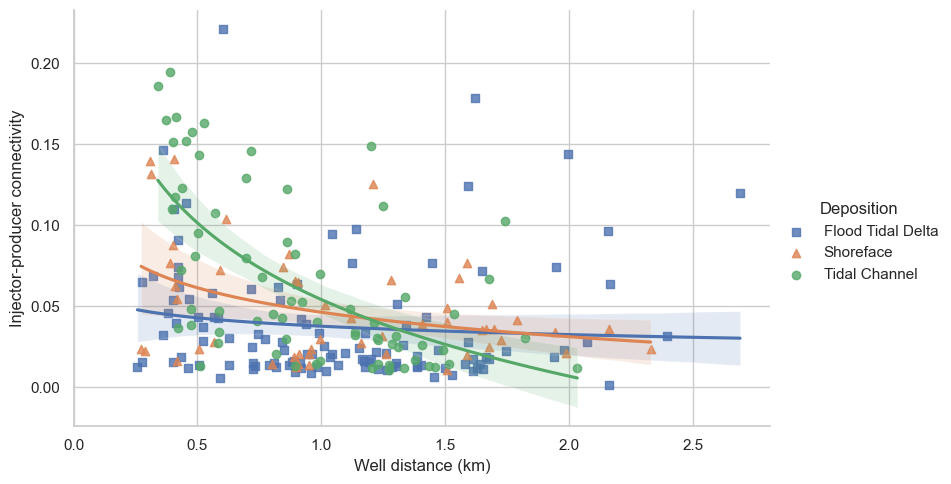

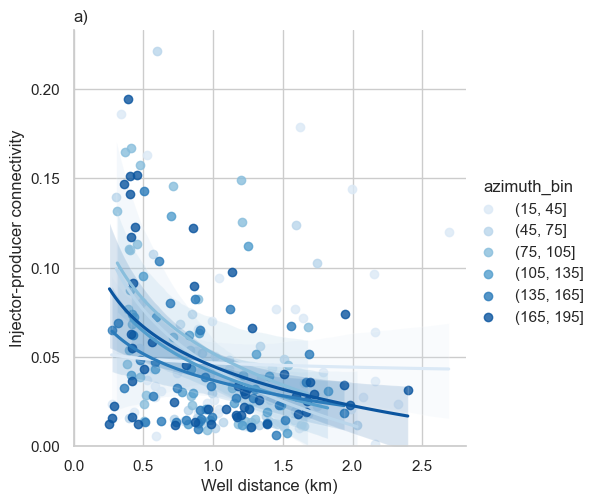

In [54]:
g = sns.lmplot(
    data=df,
    x="dist",
    y="Gain",
    hue="Deposition",
    aspect=1.61,
    markers=["s", "^", "o"],
    logx=True,
)
g.set(
    xlabel="Well distance (km)",
    xlim=(0, None),
    ylabel="Injector-producer connectivity",
)

g = sns.lmplot(
    data=df,
    x="dist",
    y="Gain",
    hue="azimuth_bin",
    aspect=1.61,
    palette="Blues",
    logx=True,
)
g.set(
    xlabel="Well distance (km)",
    xlim=(0, None),
    ylabel="Injector-producer connectivity",
    ylim=(0, None),
)
g.ax.set_title("a)", loc="left")

In [23]:
m = smf.rlm(
    "Gain ~ 1 + log_dist + azimuth_bin",
    df.assign(log_dist=lambda x: np.log(x.dist)),
    categorical="Deposition",
)
m.fit().summary()

/home/frank/Dropbox/ROZ/code/CRM/Bayesian_analysis_Senlac/venv/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['categorical']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   Gain   No. Observations:                  239
Model:                            RLM   Df Residuals:                      232
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 08 Feb 2024                                         
Time:                        22:36:58                                         
No. Iterations:                    31                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.0401      0.004      9.034      0.000       0.031       0.049
azimuth_bin[T.Interval(45, 75, closed='right')]      -0.0060      0.007     -0.842      0.400      -0.020       0.008
azimuth_bin[T.Interval(75, 105, closed='right')]      0.0100      0.007      1.340      0.180      -0.005       0.025
azimuth_bin[T.Interval(105, 135, closed='right')]    -0.0006      0.008     -0.077      0.939      -0.016       0.015
azimuth_bin[T.Interval(135, 165, closed='right')]    -0.0057      0.007     -0.792      0.429      -0.020       0.008
azimuth_bin[T.Interval(165, 195, closed='right')]    -0.0010      0.006     -0.148      0.883      -0.014       0.012
log_dist                                             -0.0213      0.004     -5.061      0.000      -0.030      -0.013
=====================================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Gain_sigma, Gain_nu, log_dist, azimuth_bin]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


Text(0.0, 1.0, 'b)')

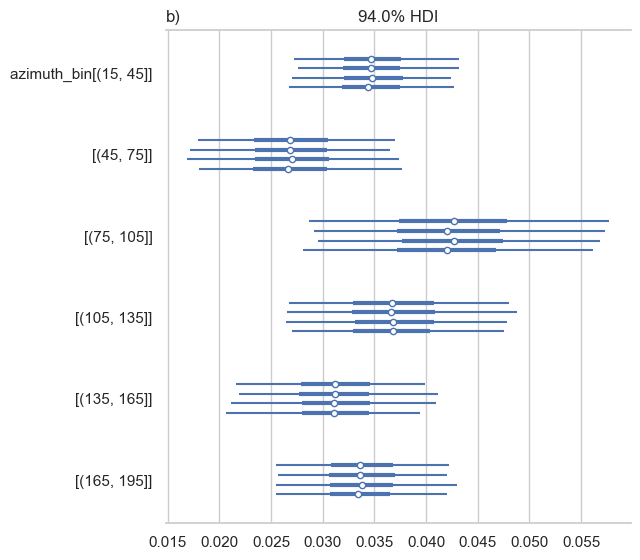

In [52]:
data = df
model = bmb.Model("Gain ~ -1 + log_dist + azimuth_bin", data, family="t")
idata = model.fit(draws=2000, random_seed=42)
model.predict(idata, kind="pps")
az.plot_forest(idata, var_names="azimuth_bin")
plt.gca().set_title("b)", loc="left")

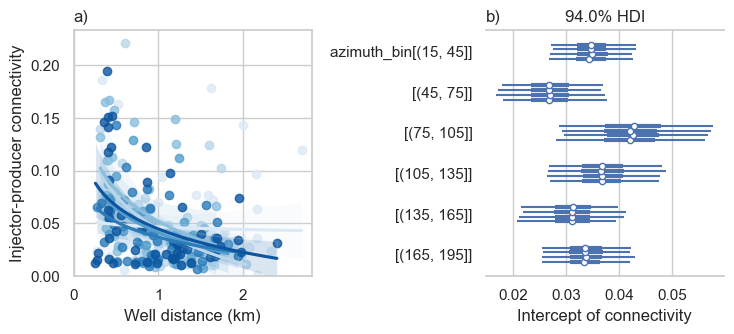

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3.5))
levels = df.azimuth_bin.cat.categories
colors = sns.color_palette("Blues", 6)
palette = {k: colors[i] for i, k in enumerate(levels)}
for azi in levels:
    sns.regplot(
        data=df[df.azimuth_bin == azi],
        x="dist",
        y="Gain",
        color=palette[azi],
        logx=True,
        ax=ax1,
    )
ax1.set(
    xlabel="Well distance (km)",
    xlim=(0, None),
    ylabel="Injector-producer connectivity",
    ylim=(0, None),
)
ax1.set_title("a)", loc="left")

az.plot_forest(idata, var_names="azimuth_bin", ax=ax2)
ax2.set_title("b)", loc="left")
ax2.set(xlabel="Intercept of connectivity")
fig.tight_layout()

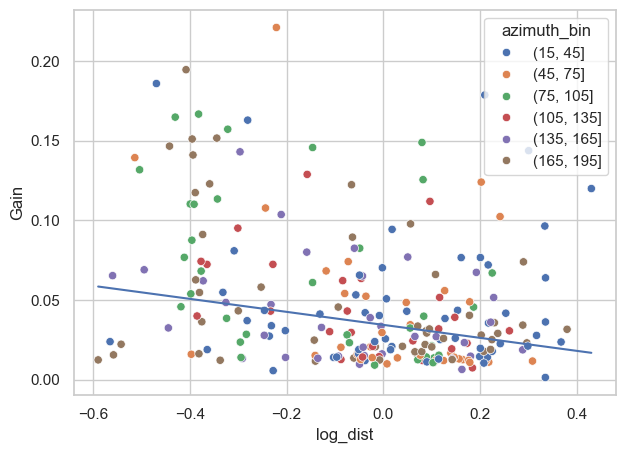

In [51]:
_, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(df, x="log_dist", y="Gain", hue="azimuth_bin", ax=ax)
x_range = np.linspace(min(df.log_dist), max(df.log_dist), 1000)
y_pred = (
    idata.posterior.log_dist.mean().item() * x_range
    + idata.posterior.azimuth_bin.mean().item()
)
plt.plot(x_range, y_pred)
# az.plot_hdi(df.log_dist, )

In [30]:
data = df
model = bmb.Model("Gain ~ -1 + log_dist + Deposition", data, categorical="Deposition")
idata = model.fit(draws=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Gain_sigma, log_dist, Deposition]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

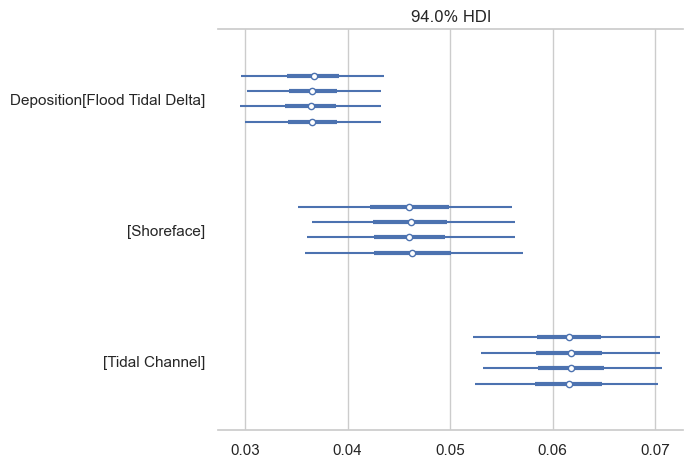

In [35]:
az.plot_forest(idata, var_names="Deposition")

Chance means are different 0.926625
Chance means are different 1.0
Chance means are different 0.9825


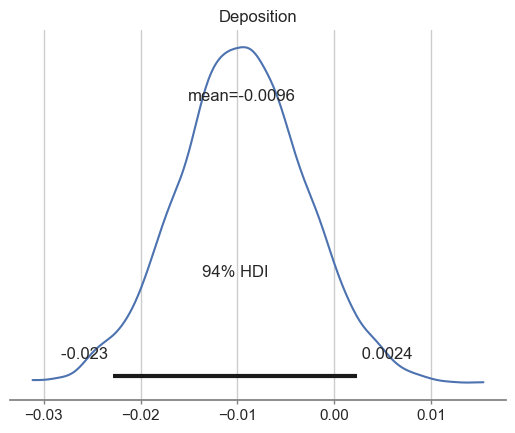

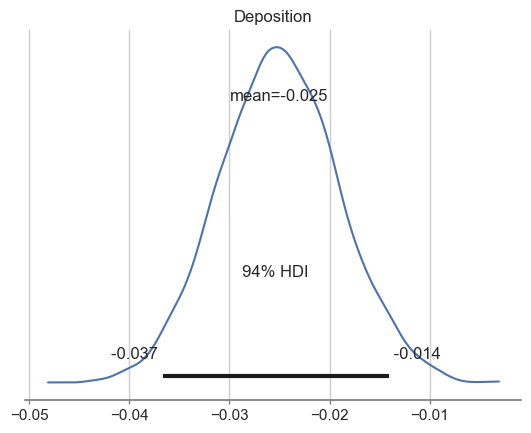

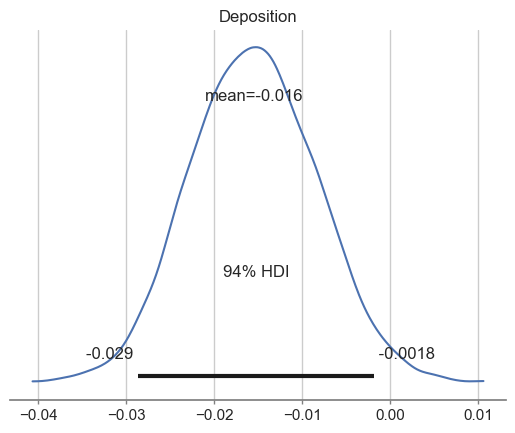

In [33]:
p = idata.posterior["Deposition"]
diff1 = p[:, :, 0] - p[:, :, 1]
diff2 = p[:, :, 0] - p[:, :, 2]
diff3 = p[:, :, 1] - p[:, :, 2]
# az.plot_posterior(xr.concat([diff1, diff2, diff3],3))
for post in (diff1, diff2, diff3):
    az.plot_posterior(post)
    print(f"Chance means are different {(post <0).mean().item()}")

In [11]:
data = df.assign(
    depo_azi=lambda x: pd.Categorical(
        x.Deposition.astype(str) + x.azimuth_bin60.astype(str)
    )
)
model = bmb.Model(
    "log_gain ~ 1 + log_dist + (log_dist | depo_azi)", data, categorical="depo_azi"
)
idata = model.fit(draws=2000, random_seed=42)

KeyError: 'log_dist'

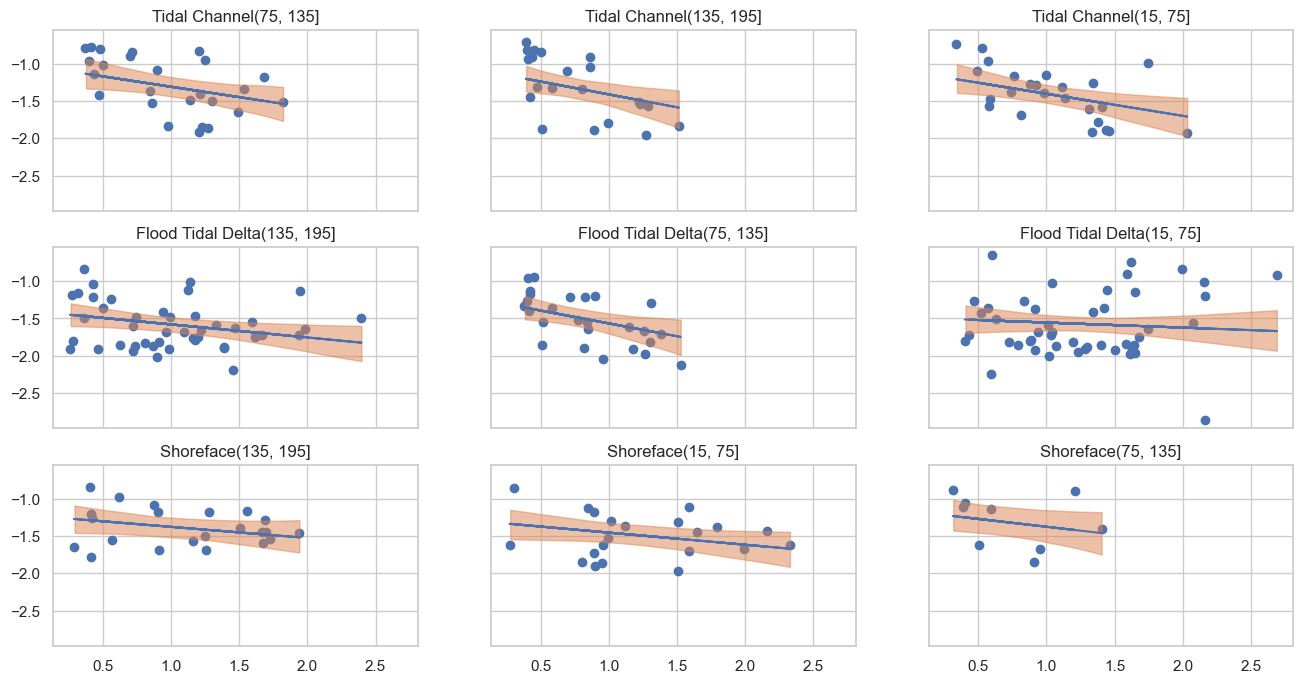

In [164]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.ravel()

model.predict(idata)
log_gain_mean = az.extract(idata)["log_gain_mean"].values

for i_ax, depo_azi in enumerate(data.depo_azi.unique()):
    ax = axes[i_ax]
    idx = data.index[data.depo_azi == depo_azi].tolist()
    ax.scatter(data.loc[idx, "dist"], data.loc[idx, "log_gain"])
    ax.set_title(depo_azi)

    az.plot_hdi(data.loc[idx, "dist"], log_gain_mean[idx].T[np.newaxis], ax=ax)
    ax.plot(data.loc[idx, "dist"], log_gain_mean[idx].mean(axis=1), color="C0")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma_a, azimuth-deposition, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


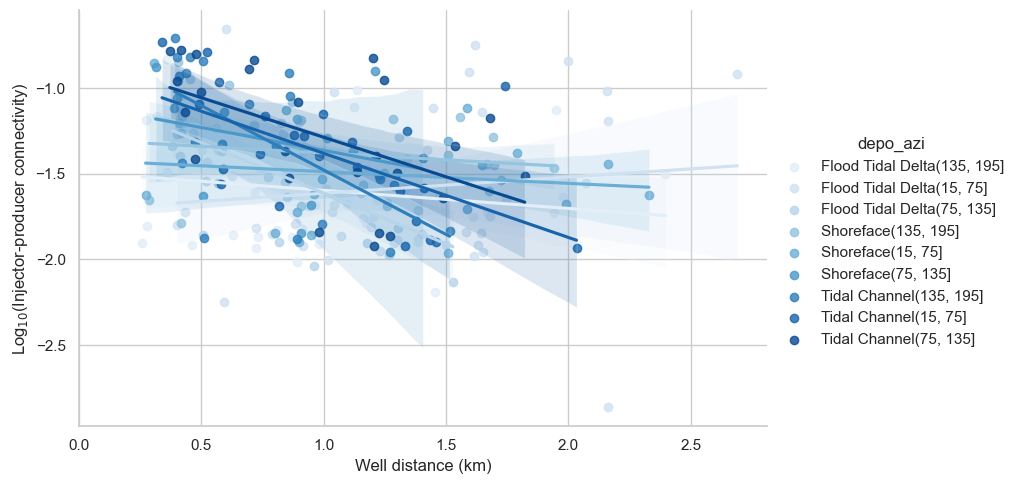

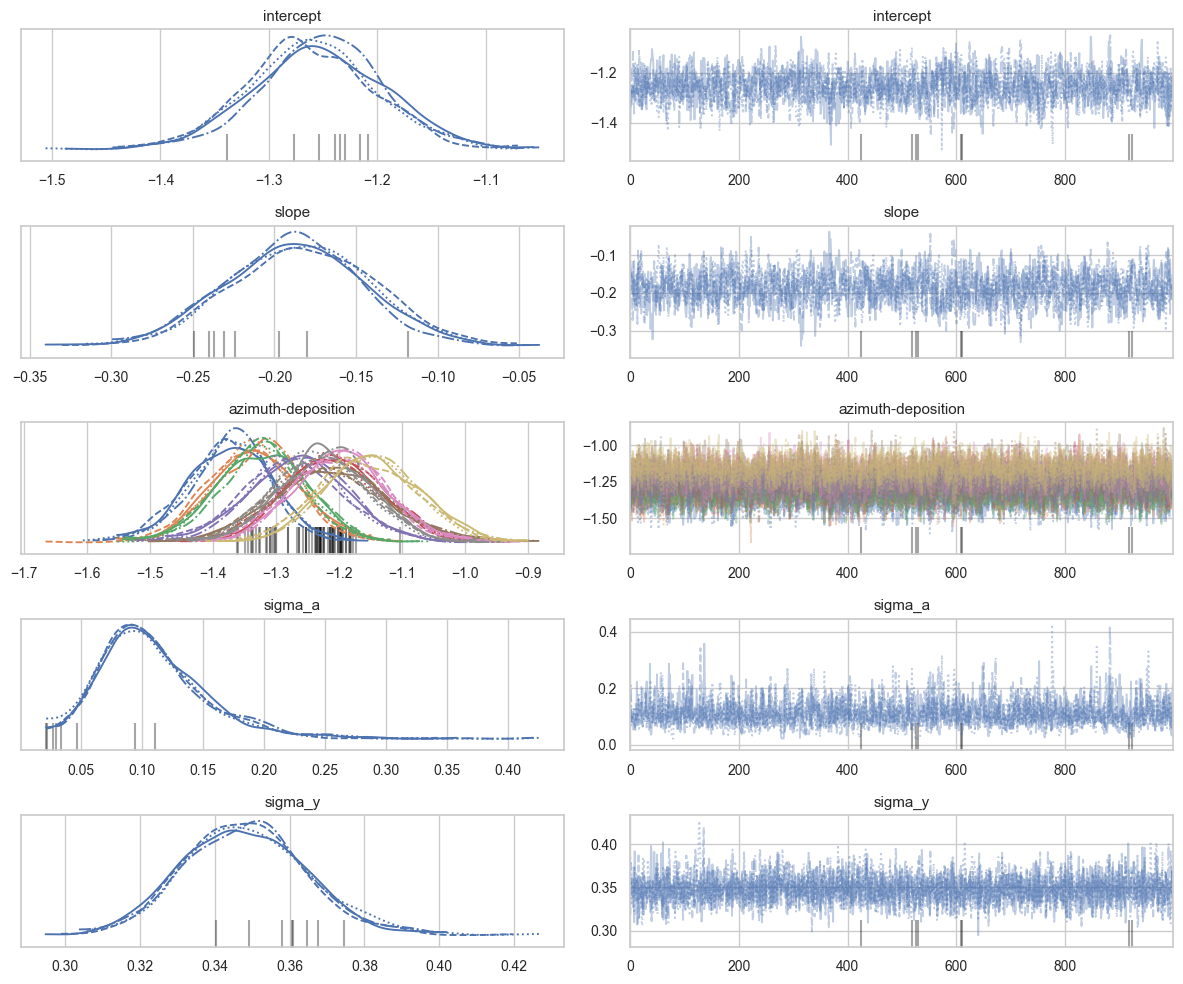

In [178]:
data = df.assign(
    depo_azi=lambda x: pd.Categorical(
        x.Deposition.astype(str) + x.azimuth_bin60.astype(str)
    )
)
g = sns.lmplot(
    data=data,
    x="dist",
    y="log_gain",
    hue="depo_azi",
    aspect=1.61,
    palette="Blues",
)
g.set(
    xlabel="Well distance (km)",
    xlim=(0, None),
    ylabel="Log$_{10}$(Injector-producer connectivity)",
)

# res = smf.ols(formula="log_gain ~ dist * depo_azi", data=data).fit()
# print(res.summary())

coords = {
    "depo_azi": data.depo_azi.cat.categories,
    "obs_idx": data.index,
}
with pm.Model(coords=coords) as depo_azi_model:
    mu_a = pm.Normal("intercept", mu=-1.26, sigma=0.2)
    mu_b = pm.Normal("slope", mu=-0.2, sigma=0.1)
    sigma_a = pm.HalfNormal("sigma_a", 0.3)

    dist = pm.MutableData("distance", data.dist, dims="obs_idx")
    depo_azi = pm.MutableData(
        "depo_azi_idx", data["depo_azi"].cat.codes, dims="obs_idx"
    )

    a_d = pm.Normal("azimuth-deposition", mu=mu_a, sigma=sigma_a, dims="depo_azi")
    sigma_y = pm.HalfNormal("sigma_y", 1)
    theta = a_d[depo_azi] + mu_b * dist

    gain = pm.Normal(
        "log_gain", mu=theta, sigma=sigma_y, observed=data.log_gain, dims="obs_idx"
    )
    # prior = pm.sample_prior_predictive()
    idata = pm.sample(target_accept=0.95)

az.plot_trace(idata)
plt.gcf().tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

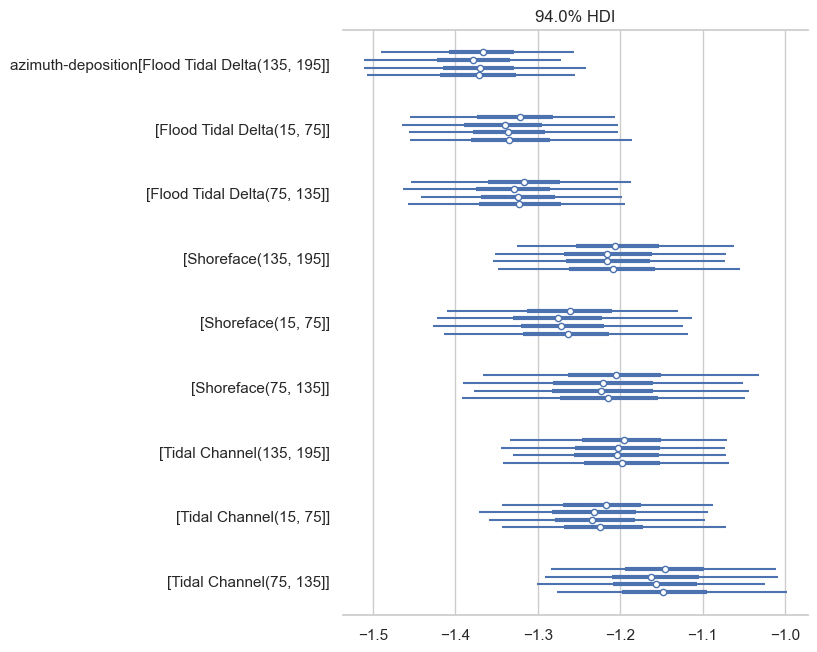

In [180]:
az.plot_forest(idata, var_names="azimuth-deposition")

In [201]:
pd.Series(
    ((p["azimuth-deposition"] - p["azimuth-deposition"].mean("depo_azi")) > 0).mean(
        "sample"
    )
)

0    0.00575
1    0.04450
2    0.11350
3    0.78950
4    0.41700
5    0.70700
6    0.83100
7    0.70150
8    0.96700
dtype: float64

In [203]:
idata.posterior["azimuth-deposition"].depo_azi

<xarray.DataArray 'depo_azi' (depo_azi: 9)>
array(['Flood Tidal Delta(135, 195]', 'Flood Tidal Delta(15, 75]',
       'Flood Tidal Delta(75, 135]', 'Shoreface(135, 195]',
       'Shoreface(15, 75]', 'Shoreface(75, 135]', 'Tidal Channel(135, 195]',
       'Tidal Channel(15, 75]', 'Tidal Channel(75, 135]'], dtype='<U27')
Coordinates:
  * depo_azi  (depo_azi) <U27 'Flood Tidal Delta(135, 195]' ... 'Tidal Channe...

<Axes: title={'center': 'azimuth-deposition'}>

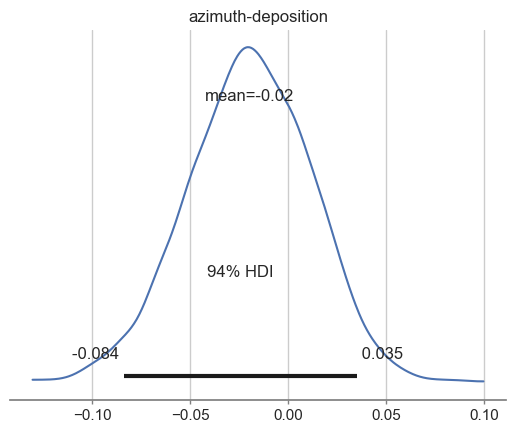

In [204]:
p = idata.posterior["azimuth-deposition"]
az.plot_posterior(p[:, :, 0] - p[:, :, 0:2].mean("depo_azi"))
# diff1 = p[:, :, 0] - p[:, :, 1]
# diff2 = p[:, :, 0] - p[:, :, 2]
# diff3 = p[:, :, 1] - p[:, :, 2]
# # az.plot_posterior(xr.concat([diff1, diff2, diff3],3))
# for post in (diff1, diff2, diff3):
#     az.plot_posterior(post)
#     print(f"Chance means are different {(post <0).mean().item()}")

In [205]:
coords = {
    "deposition": df.Deposition.cat.categories,
    "azimuth": df["azimuth_bin"].cat.categories,
    "obs_idx": df.index,
}
with pm.Model(coords=coords) as depo_azi_model:
    mu_a = pm.Normal("intercept", mu=-1.26 / 2, sigma=0.2)
    mu_b = pm.Normal("slope", mu=-0.2, sigma=0.05)
    sigma_a = pm.HalfNormal("sigma_a", 0.2)
    sigma_b = pm.HalfNormal("sigma_b", 0.1)

    dist = pm.MutableData("distance", df.dist, dims="obs_idx")
    deposition = pm.MutableData(
        "deposition_idx", df.Deposition.cat.codes, dims="obs_idx"
    )
    azi = pm.MutableData("azimuth_idx", df["azimuth_bin"].cat.codes, dims="obs_idx")

    a_d = pm.Normal("depo_intercept", mu=mu_a, sigma=sigma_a, dims="deposition")
    # b_d = pm.Normal("depo_slope", mu=mu_b, sigma=sigma_b, dims="deposition")
    a_a = pm.Normal("azi_intercept", mu=mu_a, sigma=sigma_a, dims="azimuth")
    # b_a = pm.Normal("azi_slope", mu=mu_b, sigma=sigma_b, dims="azimuth")

    sigma_y = pm.HalfCauchy("sigma_y", 2)

    theta = a_d[deposition] + mu_b * dist + a_a[azi]
    # + b_a[azi] * dist,
    #     dims="obs_idx",
    # )
    # theta = mu_a + mu_b * dist

    gain = pm.Normal(
        "log_gain", mu=theta, sigma=sigma_y, observed=df.log_gain, dims="obs_idx"
    )
    # prior = pm.sample_prior_predictive()
    idata = pm.sample(target_accept=0.95)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma_a, sigma_b, depo_intercept, azi_intercept, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


[Text(0.5, 0, 'Intercept for each class')]

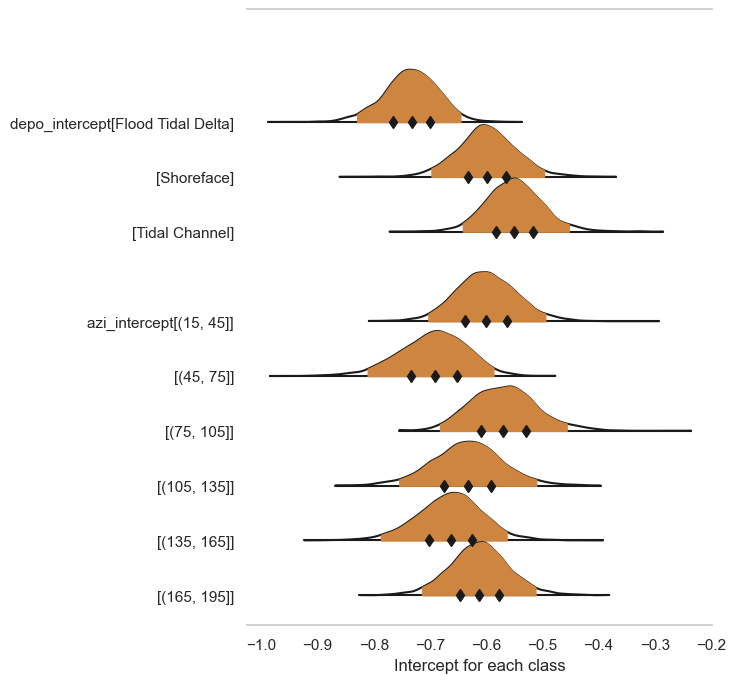

In [206]:
az.plot_forest(
    idata,
    kind="ridgeplot",
    ridgeplot_overlap=0.8,
    ridgeplot_truncate=False,
    combined=True,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    var_names=["depo", "azi"],
    filter_vars="like",
    figsize=(6, 8),
    colors="peru",
)
plt.gca().set(xlabel="Intercept for each class")

<xarray.DataArray 'azi_intercept' (azimuth: 6)>
array([0.781  , 0.06675, 0.91575, 0.46075, 0.201  , 0.6665 ])
Coordinates:
  * azimuth  (azimuth) object (15, 45] (45, 75] ... (135, 165] (165, 195]

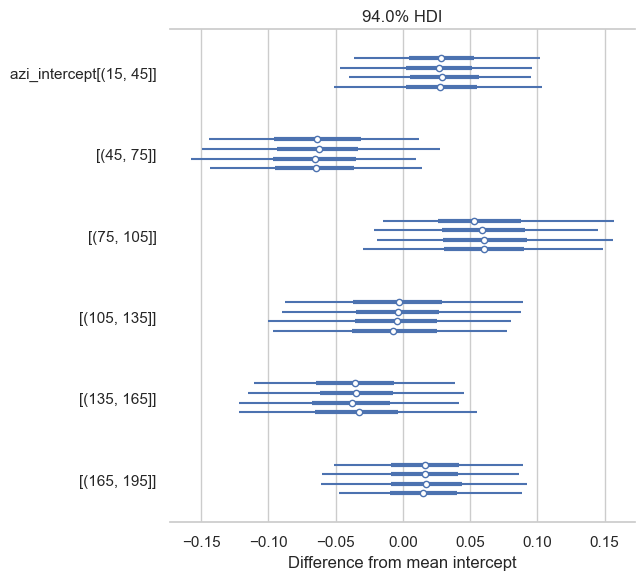

In [213]:
p = idata.posterior["azi_intercept"]
delta = p - p.mean("azimuth")
az.plot_forest(delta)
plt.gca().set(xlabel="Difference from mean intercept")
(delta > 0).mean(["draw", "chain"])

In [4]:
coords = {"regressor": ["distance"], "obs_idx": df.index}
with pm.Model(coords=coords) as pooled_model:
    a = pm.Normal("intercept", mu=-1.25, sigma=0.5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    sigma = pm.HalfCauchy("sigma", 0.5)

    dist = pm.MutableData("distance", df.dist, dims="obs_idx")

    theta = a + b * dist

    gain = pm.Normal("gain", theta, sigma=sigma, observed=df.log_gain, dims="obs_idx")
    prior = pm.sample_prior_predictive()
    idata = pm.sample()

Sampling: [gain, intercept, sigma, slopes]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


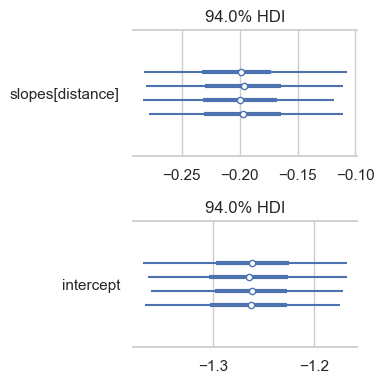

In [5]:
fig, (ax_slopes, ax_intercepts) = plt.subplots(2, 1, figsize=(4, 4))
az.plot_forest(idata, var_names="slopes", ax=ax_slopes)
az.plot_forest(idata, var_names="intercept", ax=ax_intercepts)
fig.tight_layout()

In [9]:
res = smf.ols(formula="log_gain ~ dist * Deposition", data=df).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               log_gain   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     11.71
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           4.10e-10
Time:                        16:01:28   Log-Likelihood:                -74.285
No. Observations:                 239   AIC:                             160.6
Df Residuals:                     233   BIC:                             181.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [105]:
depositions = pd.Categorical(df.Deposition)

coords = {
    "deposition": df.Deposition.cat.categories,
    "azimuth": df["azimuth_bin"].cat.categories,
    "obs_idx": df.index,
}
with pm.Model(coords=coords) as depo_azi_model:
    mu_a = pm.Normal("intercept", mu=-1.26 / 2, sigma=0.2)
    mu_b = pm.Normal("slope", mu=-0.2, sigma=0.05)
    sigma_a = pm.HalfNormal("sigma_a", 0.2)
    sigma_b = pm.HalfNormal("sigma_b", 0.1)

    dist = pm.MutableData("distance", df.dist, dims="obs_idx")
    deposition = pm.MutableData(
        "deposition_idx", df.Deposition.cat.codes, dims="obs_idx"
    )
    azi = pm.MutableData("azimuth_idx", df["azimuth_bin"].cat.codes, dims="obs_idx")

    a_d = pm.Normal("depo_intercept", mu=mu_a, sigma=sigma_a, dims="deposition")
    # b_d = pm.Normal("depo_slope", mu=mu_b, sigma=sigma_b, dims="deposition")
    a_a = pm.Normal("azi_intercept", mu=mu_a, sigma=sigma_a, dims="azimuth")
    # b_a = pm.Normal("azi_slope", mu=mu_b, sigma=sigma_b, dims="azimuth")

    sigma_y = pm.HalfCauchy("sigma_y", 2)

    theta = a_d[deposition] + mu_b * dist + a_a[azi]
    # + b_a[azi] * dist,
    #     dims="obs_idx",
    # )
    # theta = mu_a + mu_b * dist

    gain = pm.Normal(
        "log_gain", mu=theta, sigma=sigma_y, observed=df.log_gain, dims="obs_idx"
    )
    # prior = pm.sample_prior_predictive()
    idata = pm.sample(target_accept=0.95)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma_a, sigma_b, depo_intercept, azi_intercept, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


[Text(0.5, 0, 'Intercept for each class')]

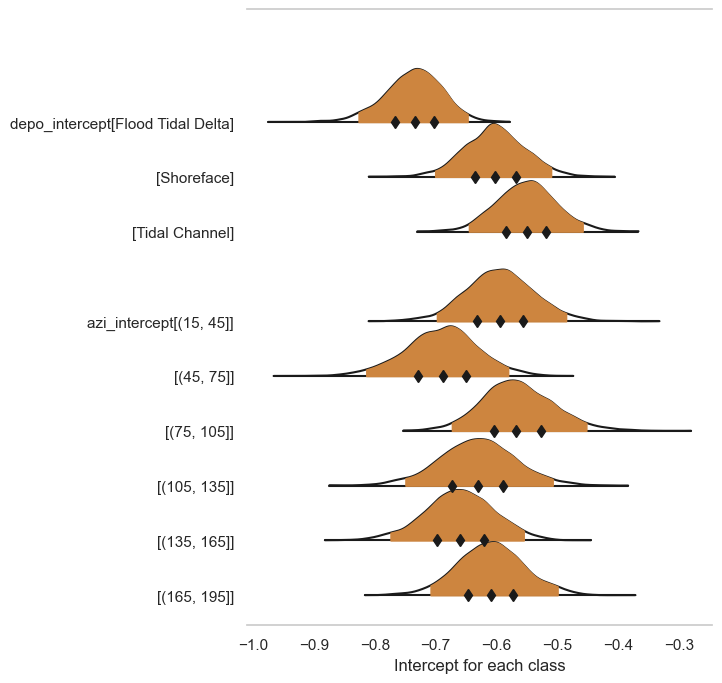

In [135]:
az.plot_forest(
    idata,
    kind="ridgeplot",
    ridgeplot_overlap=0.8,
    ridgeplot_truncate=False,
    combined=True,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    var_names=["depo", "azi"],
    filter_vars="like",
    figsize=(6, 8),
    colors="peru",
)
plt.gca().set(xlabel="Intercept for each class")

In [136]:
depositions = pd.Categorical(df.Deposition)

coords = {
    "deposition": df.Deposition.cat.categories,
    "azimuth": df["azimuth_bin60"].cat.categories,
    "obs_idx": df.index,
}
with pm.Model(coords=coords) as depo_azi_model:
    mu_a = pm.Normal("intercept", mu=-1.26 / 2, sigma=0.2)
    mu_b = pm.Normal("slope", mu=-0.2, sigma=0.05)
    sigma_a = pm.HalfNormal("sigma_a", 0.2)
    sigma_b = pm.HalfNormal("sigma_b", 0.1)

    dist = pm.MutableData("distance", df.dist, dims="obs_idx")
    deposition = pm.MutableData(
        "deposition_idx", df.Deposition.cat.codes, dims="obs_idx"
    )
    azi = pm.MutableData("azimuth_idx", df["azimuth_bin60"].cat.codes, dims="obs_idx")

    a_d = pm.Normal("depo_intercept", mu=mu_a, sigma=sigma_a, dims="deposition")
    # b_d = pm.Normal("depo_slope", mu=mu_b, sigma=sigma_b, dims="deposition")
    a_a = pm.Normal("azi_intercept", mu=mu_a, sigma=sigma_a, dims="azimuth")
    # b_a = pm.Normal("azi_slope", mu=mu_b, sigma=sigma_b, dims="azimuth")

    sigma_y = pm.HalfCauchy("sigma_y", 2)

    theta = a_d[deposition] + mu_b * dist + a_a[azi]
    # + b_a[azi] * dist,
    #     dims="obs_idx",
    # )
    # theta = mu_a + mu_b * dist

    gain = pm.Normal(
        "log_gain", mu=theta, sigma=sigma_y, observed=df.log_gain, dims="obs_idx"
    )
    # prior = pm.sample_prior_predictive()
    idata = pm.sample(target_accept=0.95)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma_a, sigma_b, depo_intercept, azi_intercept, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


[Text(0.5, 0, 'Intercept for each class')]

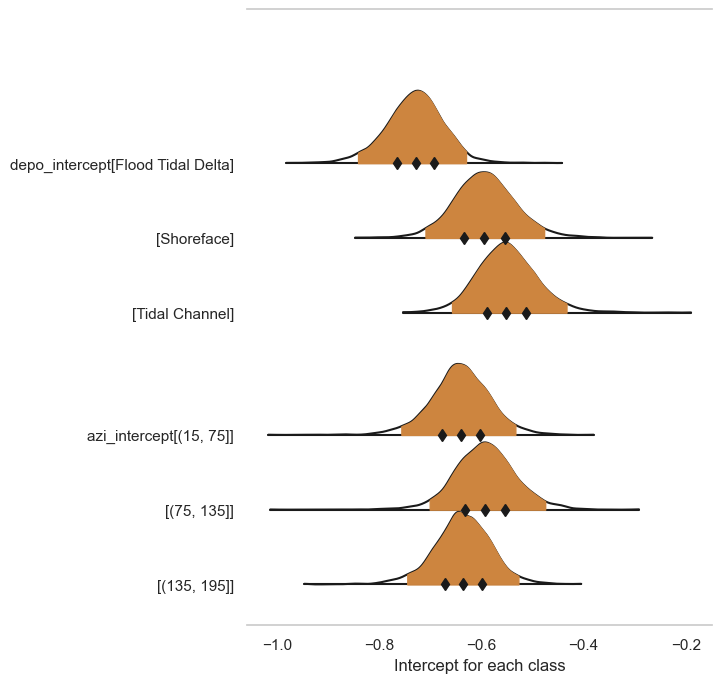

In [137]:
az.plot_forest(
    idata,
    kind="ridgeplot",
    ridgeplot_overlap=0.8,
    ridgeplot_truncate=False,
    combined=True,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    var_names=["depo", "azi"],
    filter_vars="like",
    figsize=(6, 8),
    colors="peru",
)
plt.gca().set(xlabel="Intercept for each class")

In [ ]:
depositions = pd.Categorical(df.Deposition)

coords = {
    "deposition": df.Deposition.cat.categories,
    "azimuth": df["azimuth_bin"].cat.categories,
    "obs_idx": df.index,
}
with pm.Model(coords=coords) as depo_azi_model:
    mu_a = pm.Normal("intercept", mu=-1.26 / 2, sigma=0.2)
    mu_b = pm.Normal("slopes", mu=-0.2, sigma=0.05)
    sigma_a = pm.HalfNormal("sigma_a", 0.2)
    sigma_b = pm.HalfNormal("sigma_b", 0.1)

    dist = pm.MutableData("distance", df.dist, dims="obs_idx")
    deposition = pm.MutableData(
        "deposition_idx", df.Deposition.cat.codes, dims="obs_idx"
    )
    azi = pm.MutableData("azimuth_idx", df["azimuth_bin"].cat.codes, dims="obs_idx")

    a_d = pm.Normal("depo_intercept", mu=mu_a, sigma=sigma_a, dims="deposition")
    b_d = pm.Normal("depo_slope", mu=mu_b, sigma=sigma_b, dims="deposition")
    a_a = pm.Normal("azi_intercept", mu=mu_a, sigma=sigma_a, dims="azimuth")
    # b_a = pm.Normal("azi_slope", mu=mu_b, sigma=sigma_b, dims="azimuth")

    sigma_y = pm.HalfCauchy("sigma_y", 2)

    theta = pm.Deterministic(
        "theta",
        a_d[deposition] + b_d[deposition] * dist + a_a[azi],
        # + b_a[azi] * dist,
        dims="obs_idx",
    )
    # theta = mu_a + mu_b * dist

    gain = pm.Normal(
        "log_gain", mu=theta, sigma=sigma_y, observed=df.log_gain, dims="obs_idx"
    )
    # prior = pm.sample_prior_predictive()
    idata = pm.sample(target_accept=0.95)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, sigma_a, sigma_b, depo_intercept, depo_slope, azi_intercept, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.


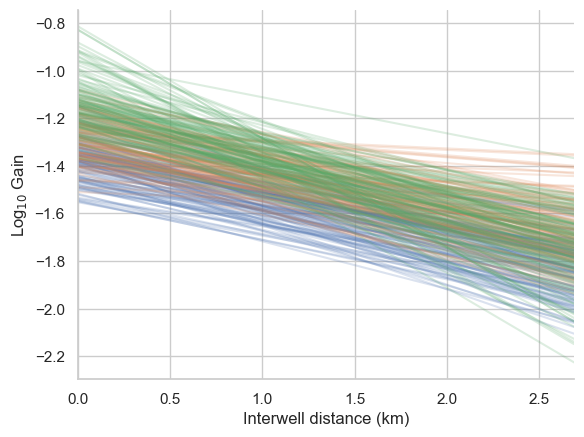

In [98]:
p = idata.posterior
x = xr.DataArray(np.linspace(0, df.dist.max(), 500), dims=["plot_dim"])
y = p["depo_intercept"] + p["depo_slope"] * x + p["azi_intercept"]

rsample = np.random.default_rng(32).choice(4000, 20)
_, ax = plt.subplots()
for depo in range(3):
    for azi in range(6):
        ax.plot(
            x,
            y.stack(sample=("chain", "draw"))[depo, :, azi, rsample],
            color=sns.color_palette()[depo],
            alpha=0.2,
        )
ax.set(
    xlabel="Interwell distance (km)", ylabel="Log$_{10}$ Gain", xlim=(0, df.dist.max())
)
sns.despine()

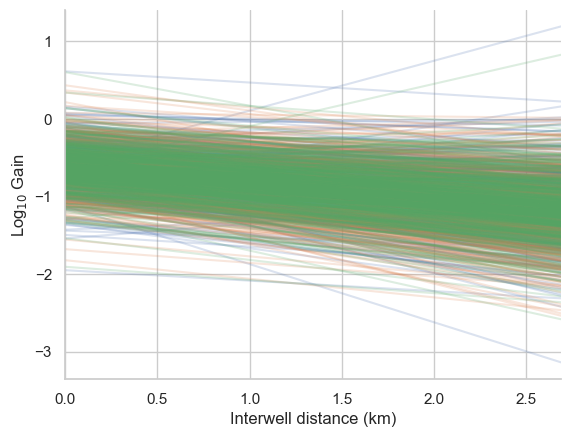

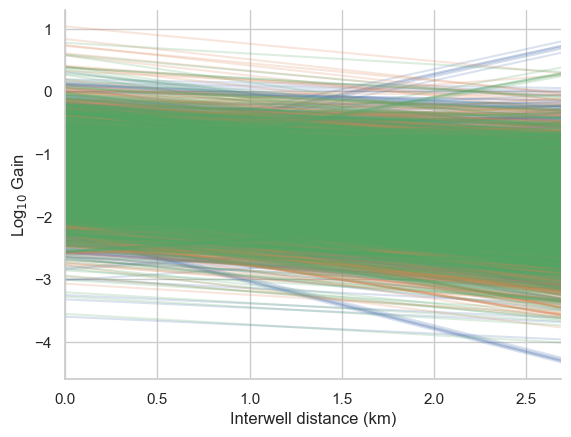

In [88]:
p = prior.prior
x = xr.DataArray(np.linspace(0, df.dist.max(), 500), dims=["plot_dim"])
y = p["depo_intercept"] + p["depo_slope"] * x

_, ax = plt.subplots()
for depo in range(3):
    ax.plot(
        x,
        y.stack(sample=("chain", "draw"))[depo],
        color=sns.color_palette()[depo],
        alpha=0.2,
    )
ax.set(
    xlabel="Interwell distance (km)", ylabel="Log$_{10}$ Gain", xlim=(0, df.dist.max())
)
sns.despine()

y = p["depo_intercept"] + p["depo_slope"] * x + p["azi_intercept"]


_, ax = plt.subplots()
for depo in range(3):
    for azi in range(6):
        ax.plot(
            x,
            y.stack(sample=("chain", "draw"))[depo, :, azi],
            color=sns.color_palette()[depo],
            alpha=0.2,
        )
ax.set(
    xlabel="Interwell distance (km)", ylabel="Log$_{10}$ Gain", xlim=(0, df.dist.max())
)
sns.despine()

/home/frank/Dropbox/ROZ/code/CRM/Bayesian_analysis_Senlac/venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


[(-10.0, 2.0)]

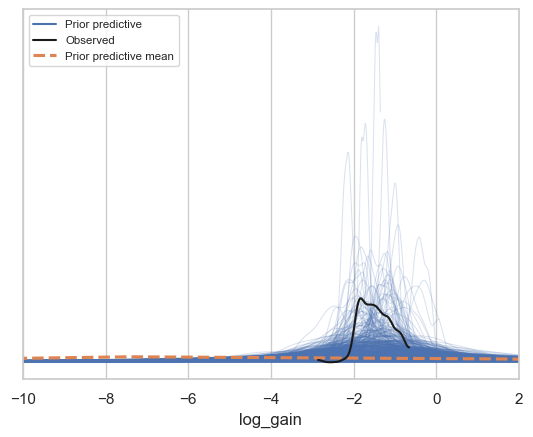

In [86]:
az.plot_ppc(prior, group="prior")
plt.gca().set(xlim=(-10, 2))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

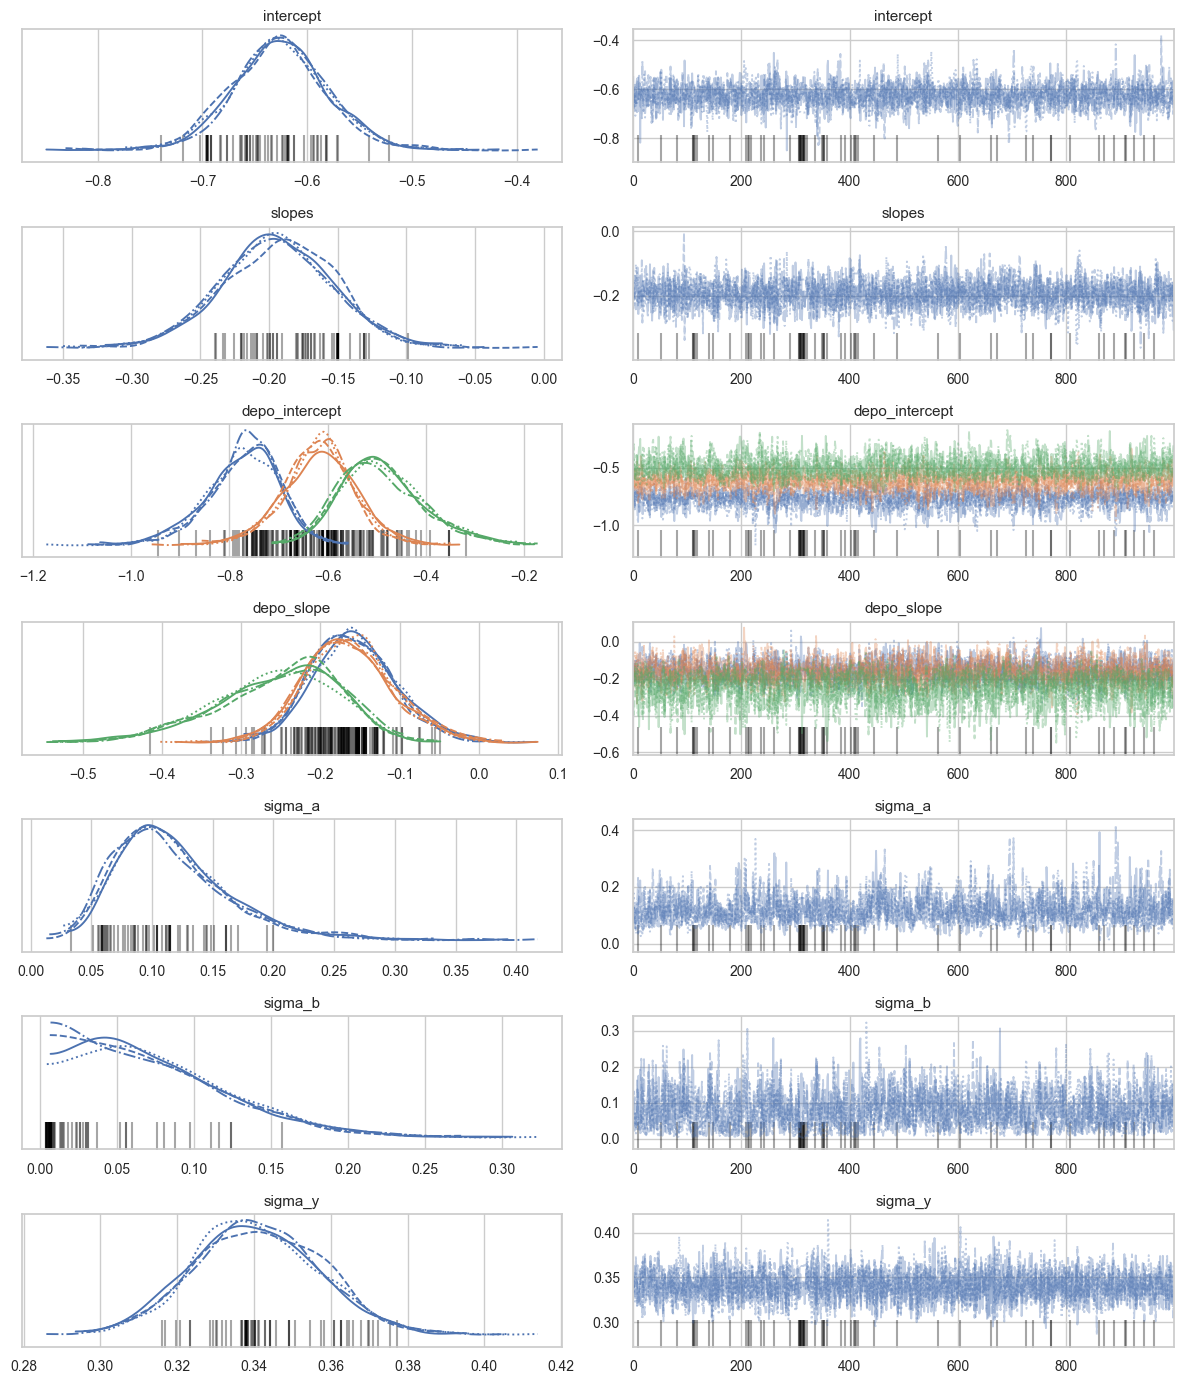

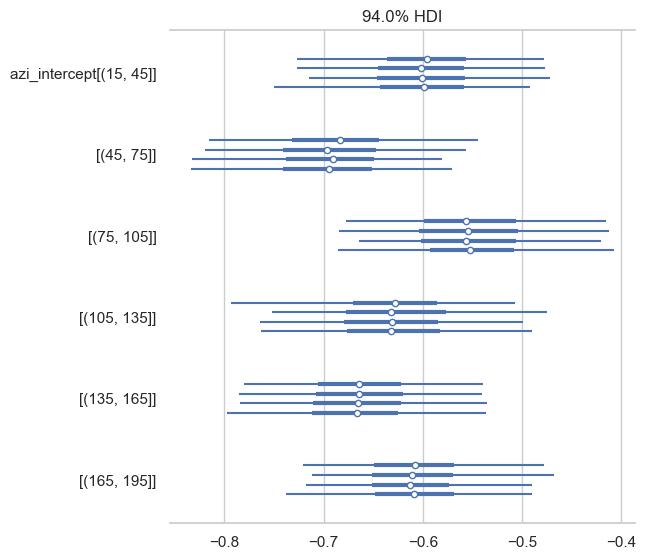

In [90]:
az.plot_trace(idata, var_names=["~theta", "~azi"], filter_vars="like")
plt.gcf().tight_layout()
az.plot_forest(idata, var_names="azi", filter_vars="like")

In [91]:
az.plot_ppc(idata)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

array([[<Axes: xlabel='distance', ylabel='log_gain'>]], dtype=object)

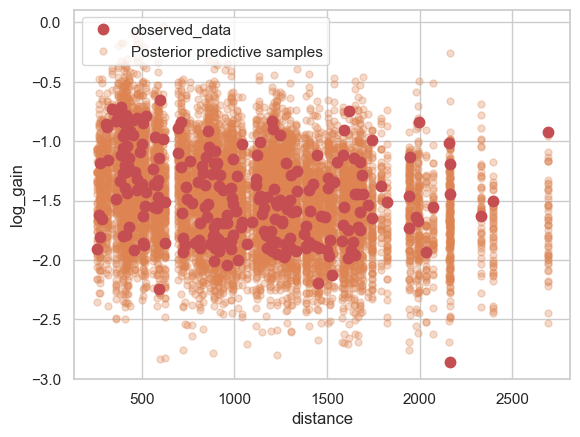

In [215]:
az.plot_lm(y="log_gain", idata=idata, x="distance", y_hat="log_gain")

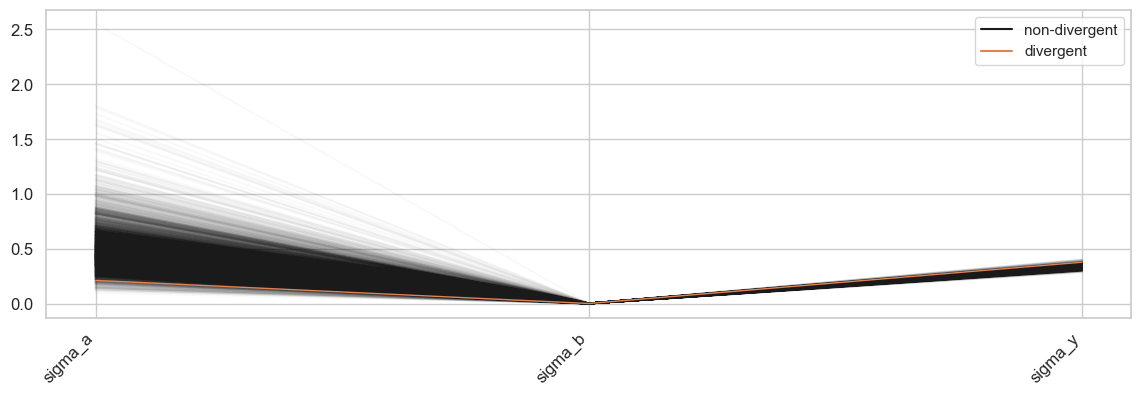

In [171]:
_, ax = plt.subplots(figsize=(14, 4))
az.plot_parallel(
    idata,
    # var_names="depo_slope",
    var_names=["sigma_a", "sigma_b", "sigma_y"],
    ax=ax,
)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha="right")
print()

/home/frank/Dropbox/ROZ/code/CRM/Bayesian_analysis_Senlac/venv/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<Axes: xlabel='log_gain'>

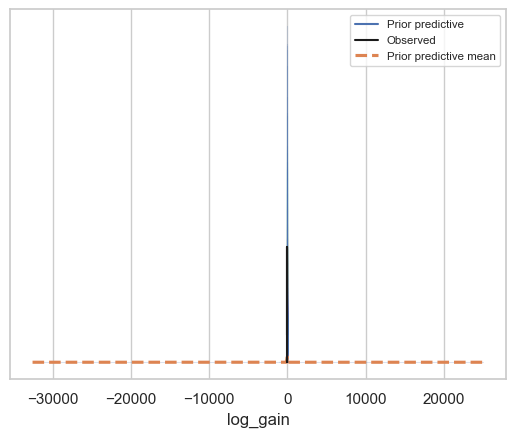

In [208]:
az.plot_ppc(prior, group="prior")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

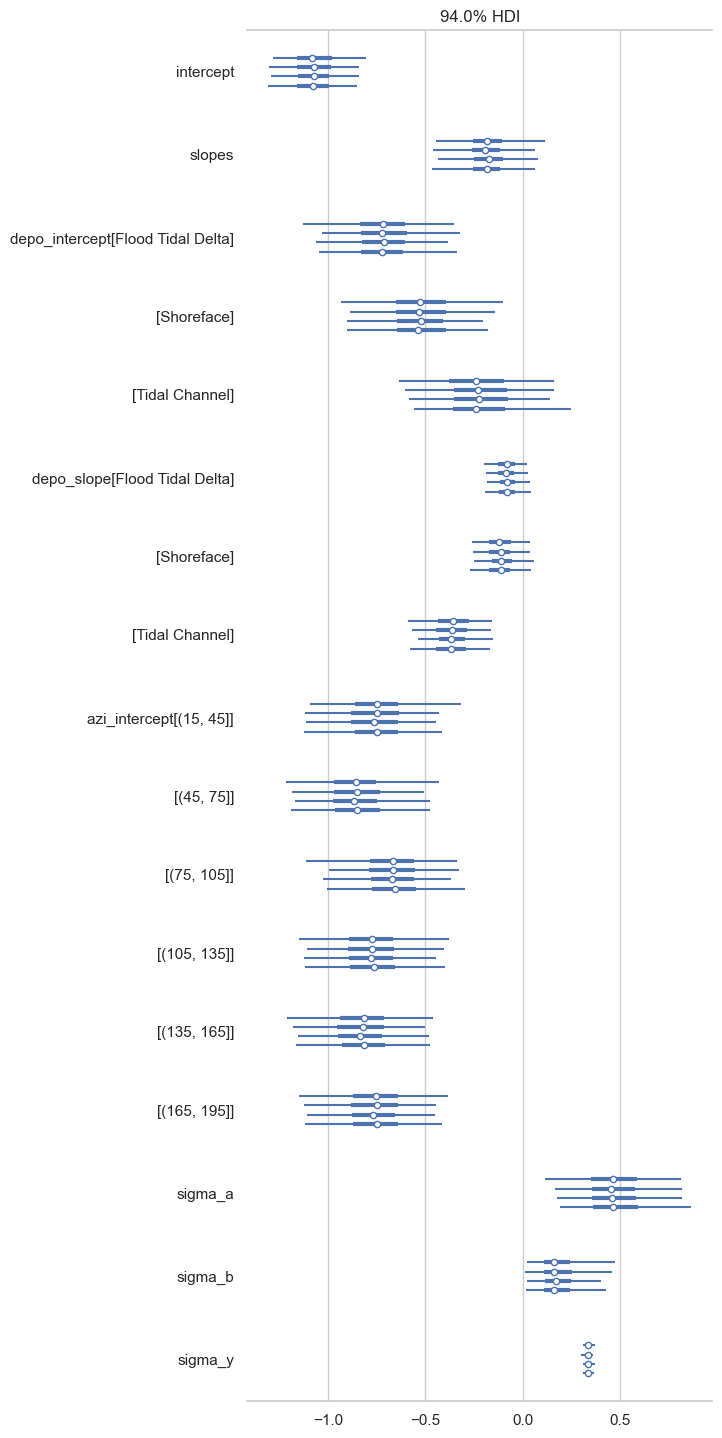

In [15]:
az.plot_forest(idata, kind="forestplot", var_names="~theta")